<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/OwenHuelU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
!pip install preliz
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-ytz3k09r
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-ytz3k09r
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=95c2c94921097df55340ddad177d5d1588b8e157b574481ddb10bf51d352499f
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2bwe15z/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
   ━

In [ ]:
import preliz as pz
import bambi as bmb
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

#**Unit 7 Project: Predicting NFL Player Receiving Metrics Using Fitting Curves**

##**Context**

In the NFL, touchdowns are everything. Getting a touchdown means at least 6 points on the board for your team, a massive boost. Touchdowns can be gained through running the ball, sure, but an explosive passing play is one of the most cool ways to get one. Players that can generate a lot of receiving touchdowns are often the most sought after and impactful players in the league.

I want to try to predict how many receiving touchdowns an NFL player might record in a season based on a number of different statistics. I'll be using bambi to create Polynomial GLMs, B-Splines, and Gaussian Processes to carry out my analysis.

##**Data**

Before we begin to create and test models, here is the raw data.

In [ ]:
#raw data csv from my github
url_nfl = 'https://raw.githubusercontent.com/OwenHuels/data-science/main/rec24.csv'

nfl = pd.read_csv(url_nfl)

#view data
nfl

,Player,Age,Team,Pos,G,GS,Tgt,Rec,Yds,Y/R,...,1D,Succ%,Lng,R/G,Y/G,Ctch%,Y/Tgt,Fmb,Awards,-9999
0,Ja'Marr Chase,24,CIN,WR,17,16,175,127,1708,13.4,...,75,62.3,70.0,7.5,100.5,72.6,9.8,0,PBAP-1AP MVP-8AP OPoY-3,ChasJa00
1,Amon-Ra St. Brown,25,DET,WR,17,17,141,115,1263,11.0,...,73,70.2,66.0,6.8,74.3,81.6,9.0,1,PBAP-1AP OPoY-11,StxxAm00
2,Brock Bowers,22,LVR,TE,17,16,153,112,1194,10.7,...,61,60.8,57.0,6.6,70.2,73.2,7.8,0,PBAP-1AP ORoY-2,BoweBr01
3,Trey McBride,25,ARI,TE,16,16,147,111,1146,10.3,...,63,63.3,37.0,6.9,71.6,75.5,7.8,0,PB,McBrTr01
4,Malik Nabers,21,NYG,WR,15,13,170,109,1204,11.0,...,55,51.2,59.0,7.3,80.3,64.1,7.1,1,PBAP ORoY-5,NabeMa00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,Jameis Winston,30,CLE,QB,12,7,0,0,0,NaN,...,0,NaN,NaN,0.0,0.0,NaN,NaN,5,NaN,WinsJa00
590,Tristan Wirfs,25,TAM,T,16,16,0,0,9,NaN,...,0,NaN,9.0,0.0,0.6,NaN,NaN,1,PBAP-1,WirfTr00
591,Bryce Young,23,CAR,QB,14,12,0,0,0,NaN,...,0,NaN,NaN,0.0,0.0,NaN,NaN,5,NaN,YounBr01
592,Dareke Young,25,SEA,WR,14,0,1,0,0,NaN,...,0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,YounDa02


In [ ]:
#rename columns to fix errors later with syntax
nfl.rename(columns={'Y/R': 'YpR', 'Y/G': 'YpG', 'R/G': 'RpG', 'Y/Tgt':'YpTgt', '1D':'FD', 'Succ%':'SuccP', 'Ctch%':'CtchP'}, inplace=True)
#remove non traditional receiving players from the data set (and players with no yards)
nfl = nfl.query('Pos != "QB" & Pos != "T" & Pos != "QB" & Pos != "DL" & Pos != "S" & Pos != "P" & Pos != "LB" & Pos != "OL" & Pos != "OT" & Pos != "CB" & Pos != "DE" & Pos != "C" & Pos != "FS" & Pos != "DB" & Yds != 0 & Rec >= 5')
nfl.dropna(axis=0, subset='Lng', inplace=True)
#reset indexes after removal to make the data look nicer
nfl.reset_index(drop=True, inplace=True)
nfl

<ipython-input-4-ddfc8df72d3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nfl.dropna(axis=0, subset='Lng', inplace=True)


,Player,Age,Team,Pos,G,GS,Tgt,Rec,Yds,YpR,...,FD,SuccP,Lng,RpG,YpG,CtchP,YpTgt,Fmb,Awards,-9999
0,Ja'Marr Chase,24,CIN,WR,17,16,175,127,1708,13.4,...,75,62.3,70.0,7.5,100.5,72.6,9.8,0,PBAP-1AP MVP-8AP OPoY-3,ChasJa00
1,Amon-Ra St. Brown,25,DET,WR,17,17,141,115,1263,11.0,...,73,70.2,66.0,6.8,74.3,81.6,9.0,1,PBAP-1AP OPoY-11,StxxAm00
2,Brock Bowers,22,LVR,TE,17,16,153,112,1194,10.7,...,61,60.8,57.0,6.6,70.2,73.2,7.8,0,PBAP-1AP ORoY-2,BoweBr01
3,Trey McBride,25,ARI,TE,16,16,147,111,1146,10.3,...,63,63.3,37.0,6.9,71.6,75.5,7.8,0,PB,McBrTr01
4,Malik Nabers,21,NYG,WR,15,13,170,109,1204,11.0,...,55,51.2,59.0,7.3,80.3,64.1,7.1,1,PBAP ORoY-5,NabeMa00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,Ben Sinnott,22,WAS,TE,17,2,5,5,28,5.6,...,2,40.0,12.0,0.3,1.6,100.0,5.6,0,NaN,SinnBe00
346,Ben Skowronek,27,PIT,WR,10,1,5,5,69,13.8,...,4,80.0,23.0,0.5,6.9,100.0,13.8,0,NaN,SkowBe00
347,Kimani Vidal,23,LAC,RB,10,0,9,5,62,12.4,...,2,33.3,38.0,0.5,6.2,55.6,6.9,1,NaN,VidaKi00
348,Johnny Wilson,23,PHI,WR,16,4,15,5,38,7.6,...,3,26.7,9.0,0.3,2.4,33.3,2.5,0,NaN,WilsJo03


Here is a visualization of my data based primarily on yards, which I suspect will be my primary predictor.

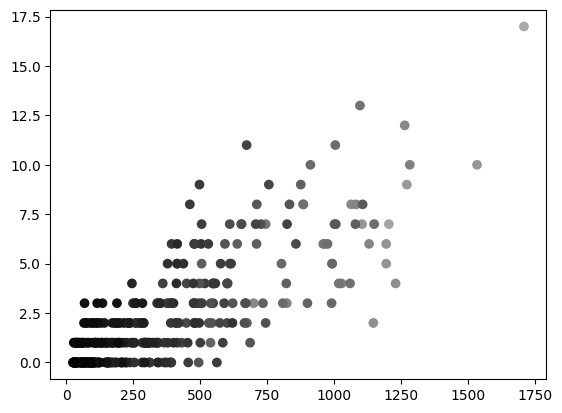

In [ ]:
x = nfl.Yds.tolist()
y = nfl.TD.tolist()
z = nfl.Tgt.tolist()

color = [str(item/(max(z)+max(z)/2)) for item in z]

plt.scatter(x, y, c=color)

plt.show()

Some of these variables are important, and some are not. The following are the ones I decided to include when creating my initial DAG, because I thought they would have the most impactful relationships.

* Pos (Position)
* GS (Games Started)
* Tgt (Targets)
* Rec (Receptions)
* Yds (Yards)
* YpR (Yards per Reception)
* FD (First Downs)
* SuccP (Success Percentage)
* Lng (Long)

##**Models**

After drawing my DAG, I think that the strongest predictor will be yards by far, so I'll try a bunch of models with different variations of that alongside other predictors, or with just other strong predictors.

Here's just a baseline model, standard linear with no frills attached.

In [ ]:
formula_nfl_1 = bmb.Formula(
    "TD ~ Yds",
)

model_poly_1 = bmb.Model(formula_nfl_1, nfl, family="negativebinomial")

idata_poly_1 = model_poly_1.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


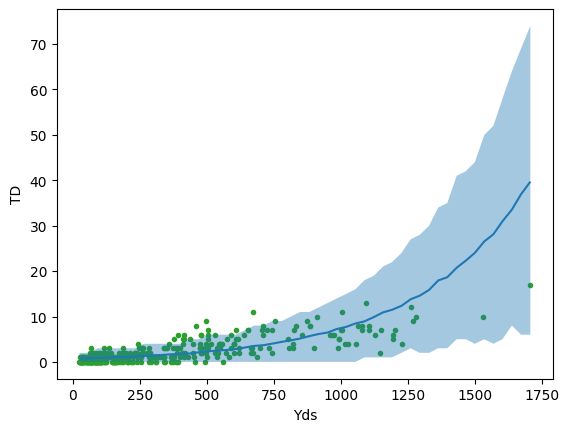

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

This doesn't look great, we can definitely do better. It way overpredicts touchdowns for players with a high number of yards. Let's try some polynomial models.

In [ ]:
formula_nfl_3 = bmb.Formula(
    "TD ~ poly(Yds, degree=3)",
)

model_poly_3 = bmb.Model(formula_nfl_3, nfl, family="negativebinomial")

idata_poly_3 = model_poly_3.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


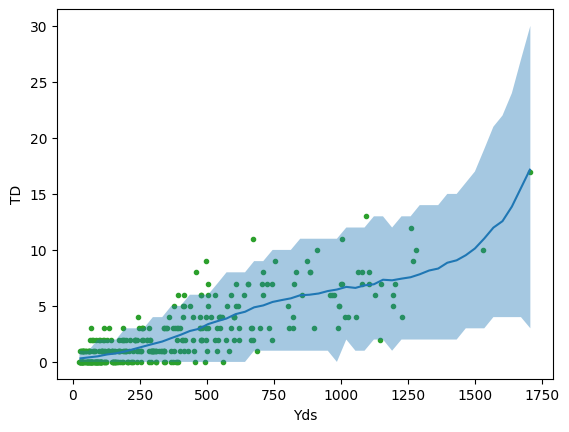

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_3, idata_poly_3, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

In [ ]:
formula_nfl_3_pos = bmb.Formula(
    "TD ~ poly(Yds, degree=3) + Pos",
)

model_poly_3_pos = bmb.Model(formula_nfl_3_pos, nfl, family="negativebinomial")

idata_poly_3_pos = model_poly_3_pos.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


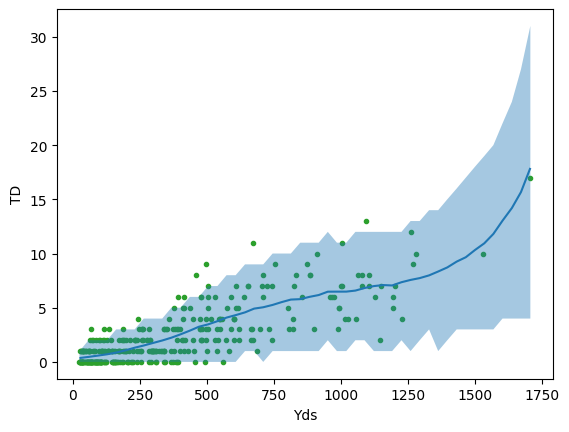

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_3_pos, idata_poly_3_pos, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

In [ ]:
formula_nfl_3_comb = bmb.Formula(
    "TD ~ poly(Rec, degree=3) + poly(Yds, degree=3)",
)

model_poly_3_comb = bmb.Model(formula_nfl_3_comb, nfl, family="negativebinomial")

idata_poly_3_comb = model_poly_3_comb.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


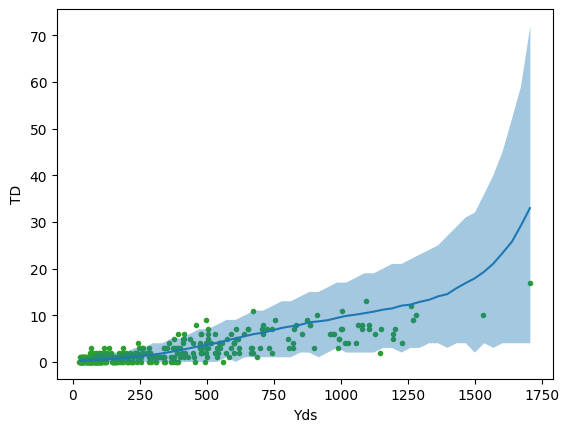

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_3_comb, idata_poly_3_comb, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

I'm curious to see how a distributional model will do, so I'll run one of those too.

In [ ]:
formula_nfl_1_dis = bmb.Formula(
    "TD ~ Yds",
    "sigma ~ poly(Yds, degree=2)"
)

model_poly_1_dis = bmb.Model(formula_nfl_1_dis, nfl)

idata_poly_1_dis = model_poly_1_dis.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


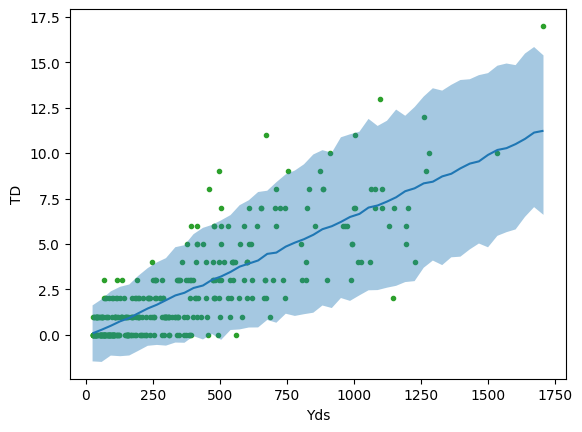

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_1_dis, idata_poly_1_dis, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

In [ ]:
formula_nfl_3_rate = bmb.Formula(
    "TD ~ poly(YpG, degree=3)"
)

model_poly_3_rate = bmb.Model(formula_nfl_3_rate, nfl, family="negativebinomial")

idata_poly_3_rate = model_poly_3_rate.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


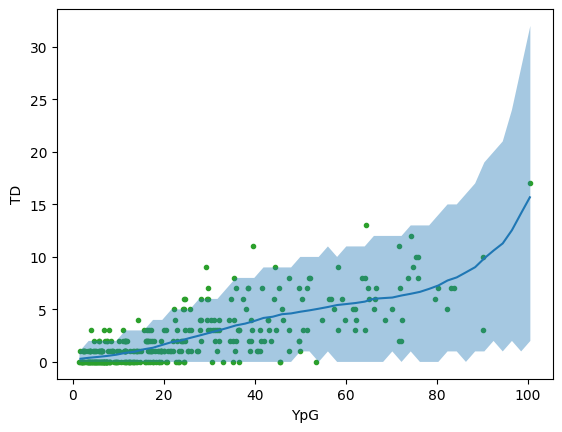

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_3_rate, idata_poly_3_rate, "YpG", pps=True)
#raw data
plt.plot(nfl.YpG, nfl.TD, "C2.", zorder=-3)

In [ ]:
formula_nfl_3_total = bmb.Formula(
    "TD ~ poly(Yds, degree=3) + Lng"
)

model_poly_3_total = bmb.Model(formula_nfl_3_total, nfl, family="negativebinomial")

idata_poly_3_total = model_poly_3_total.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


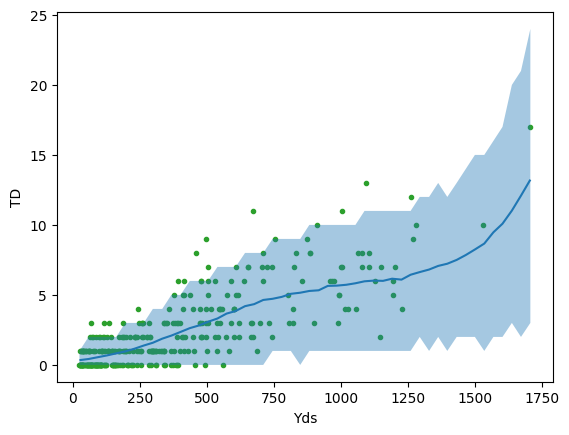

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_3_total, idata_poly_3_total, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

Here's some models with hierarchy or interaction terms thrown in based on position, which I think will affect results heavily (wide receivers tend to have a stronger correlation with yards to touchdowns than any other position from what I've observed).

In [ ]:
formula_nfl_3_total_int = bmb.Formula(
    "TD ~ poly(Yds, degree=3) + Lng + Yds:Pos"
)

model_poly_3_total_int = bmb.Model(formula_nfl_3_total_int, nfl, family="negativebinomial")

idata_poly_3_total_int = model_poly_3_total_int.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


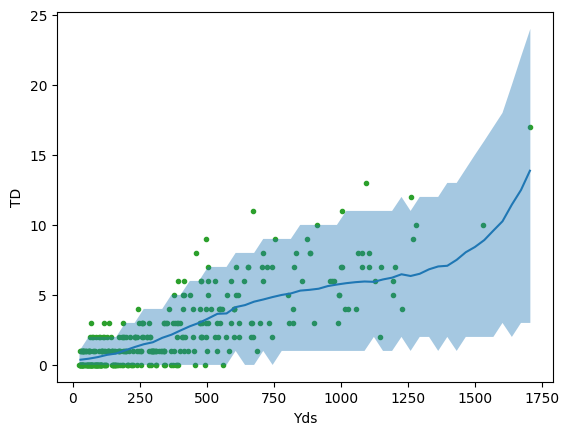

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_3_total_int, idata_poly_3_total_int, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

Most of the models so far have looked pretty successful, so I'm not sure if a more poweful model is necessary, but here are some b-splines for fun.

In [ ]:
num_knots = 3
knots = np.linspace(0, 1708, num_knots+2)[1:-1]
model_spline_3 = bmb.Model("TD ~ bs(Yds, degree=3, knots=knots)", nfl, family="negativebinomial")
idata_spline_3 = model_spline_3.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


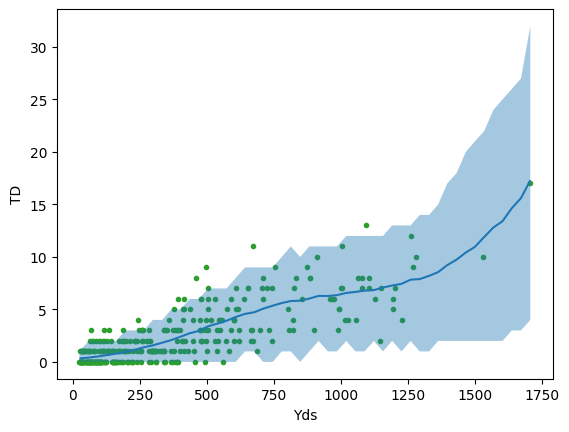

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_spline_3, idata_spline_3, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

In [ ]:
knots_manual = [250, 750, 1250]
model_spline_manual = bmb.Model("TD ~ bs(Yds, degree=2, knots=knots_manual)", nfl, family="negativebinomial")
idata_spline_manual = model_spline_manual.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


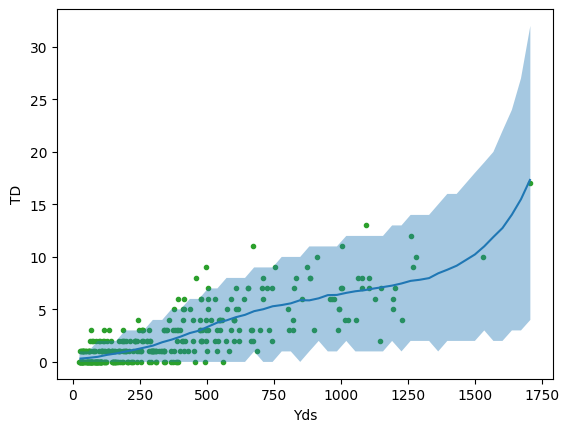

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_spline_manual, idata_spline_manual, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

In [ ]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:
TD = nfl["TD"].values
Yds = nfl["Yds"].values[:,None]

This is definitely overkill for the complexity of this data, but just because I feel like it, here's a HSGP (Gaussian Process) that should theoretically perfectly model the data. It's worth noting that you can't run an elpd_loo calculation on this, so I'm not sure exactly how it compares to the other models, but to me I think the trend is too weak in many places. Then again, the 3rd degree polynomials spike up at the end in a way that I don't think is accurate, so I might consider this model better for its behavior at the far right end.

In [ ]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(Yds))
}

priors = {
    "hsgp(Yds, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("TD ~ 0 + hsgp(Yds, m=10, c=1.5)", nfl, family="negativebinomial", priors=priors)
idata_hsb = model_hsb.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


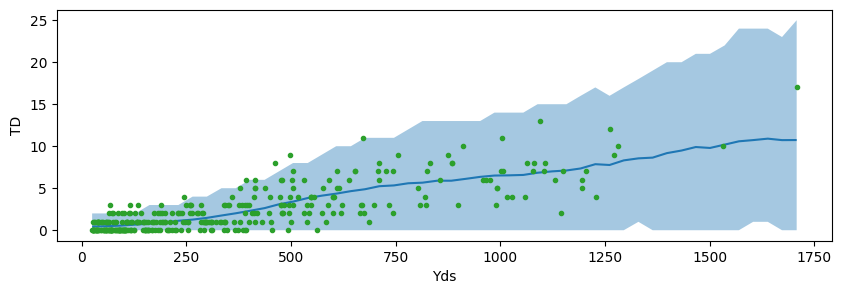

In [ ]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["Yds"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(nfl["Yds"].values, nfl["TD"].values, "C2.")

In [ ]:
cmp_df_bmb = az.compare( {"Poly 3Yds":idata_poly_3,"Poly 3Yds Dis Yds":idata_poly_1_dis,"Poly 3YpR":idata_poly_3_rate,
                          "Poly 3Yds 1YpR":idata_poly_3_total,"Poly 3Yds 1YpR Int YdsPos":idata_poly_3_total_int,
                          "Poly 1Yds":idata_poly_1,"BSpline3 3Yds":idata_spline_3, "Poly 3Yds 3Rec":idata_poly_3_comb,
                          "Poly 3Yds 1Pos":idata_poly_3_pos, "BSplineManual 1Yds":idata_spline_manual} )
cmp_df_bmb

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Poly 3Yds 1YpR,0,-535.999448,4.853481,0.000000,7.545975e-01,16.595786,0.000000,True,log
Poly 3Yds,1,-537.532000,3.878883,1.532552,2.484606e-11,16.644651,2.199026,False,log
Poly 3Yds 1YpR Int YdsPos,2,-538.053468,7.949863,2.054020,2.301428e-11,16.756718,1.935729,True,log
Poly 3Yds 1Pos,3,-538.313426,6.787760,2.313978,2.454025e-01,16.814625,3.028300,False,log
Poly 3Yds 3Rec,4,-538.690210,6.827189,2.690762,2.397481e-11,16.708690,2.317196,False,log
BSplineManual 1Yds,5,-539.527538,5.458453,3.528089,2.303662e-11,16.696358,2.140193,False,log
BSpline3 3Yds,6,-540.892994,6.696566,4.893546,2.220205e-11,16.790780,2.317290,True,log
Poly 3YpR,7,-570.374729,4.543661,34.375281,1.709411e-11,17.477428,6.921997,False,log
Poly 1Yds,8,-574.862203,2.819918,38.862755,2.819841e-11,17.048622,7.999732,False,log
Poly 3Yds Dis Yds,9,-590.925456,6.907221,54.926008,0.000000e+00,18.044974,9.381687,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

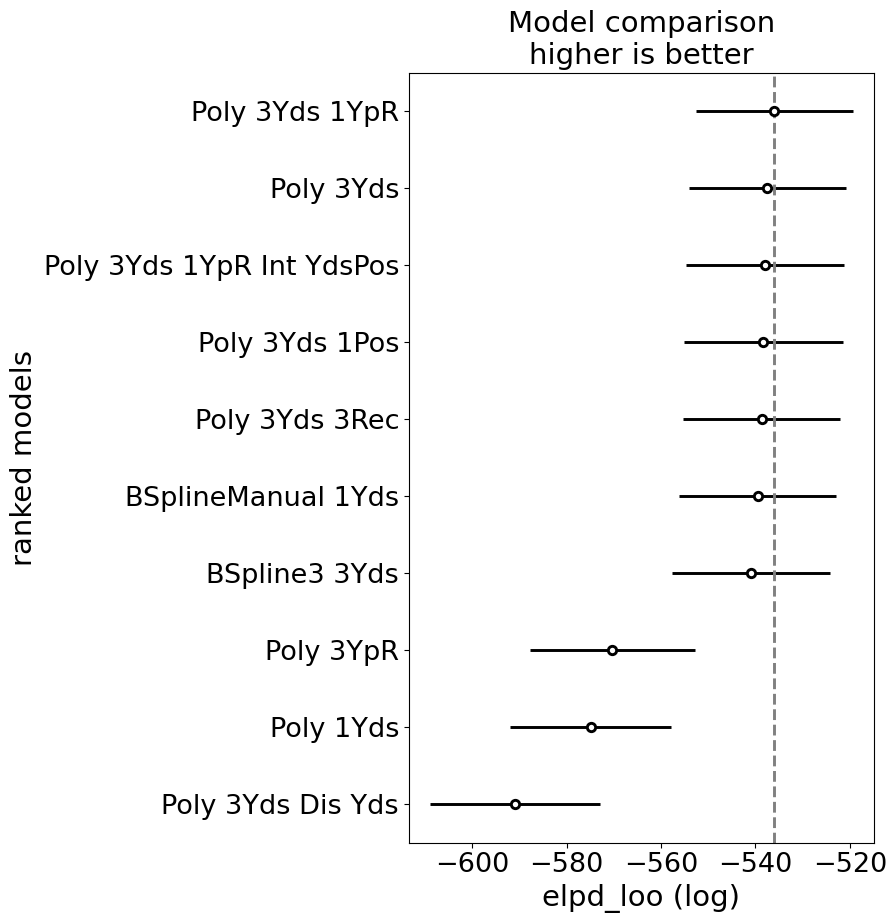

In [ ]:
az.plot_compare(cmp_df_bmb)

<Axes: xlabel='TD'>

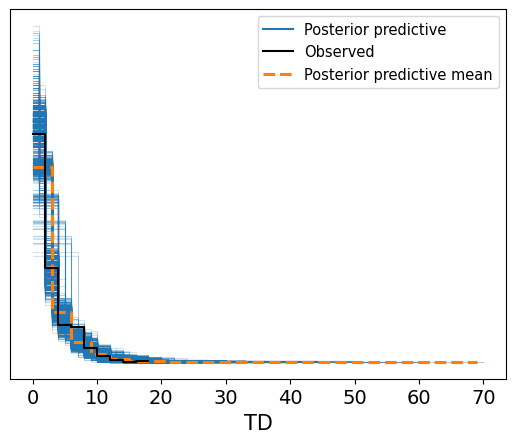

In [ ]:
model_hsb.predict(idata_hsb, kind="response")
az.plot_ppc(idata_hsb)

<Axes: xlabel='TD'>

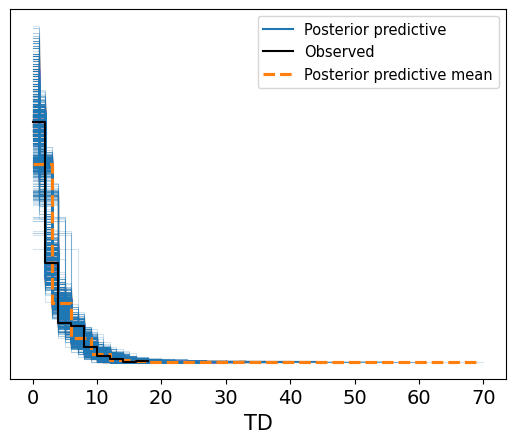

In [ ]:
model_poly_3.predict(idata_poly_3, kind="response")
az.plot_ppc(idata_poly_3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


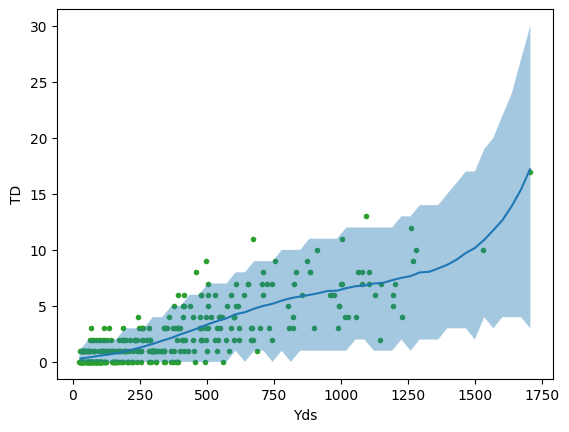

In [ ]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_3, idata_poly_3, "Yds", pps=True)
#raw data
plt.plot(nfl.Yds, nfl.TD, "C2.", zorder=-3)

##**Conclusion**

Based on the elpd_loo and the posterior predictive, I'd say the model using just a degree three polynomial with yards as the predictor or the HGSP are probably the best models. This is the model named "Poly 3Yds" in the list of elpd_loos. It has the second highest elpd_loo, very close to that the best performing model. I selected this model over the top performing one to avoid overfitting; the top one is this model plus yards per reception, so it has more variables than needed.

It was really interesting to me that the position hierarchy or interaction term seemed completely unnecessary to making a well performing model. I would have expected it to completely flounder without, but it seems just fine. I would have thought that tight ends would have had a generally weaker trend between yards and touchdowns than wide receiver because of how often tight ends are used for short plays and blocking rather than deep routes with the goal of shooting for a touchdown (same with running backs), but I guess my assumption was misguided.

From observing the plot of the model I ended up going with, it seems like the strongest predictor for sacks is total yards, which makes sense. You kind of need to get a lot of yards to get a lot of touchdowns because both indicate movement down the field, and yards is better than any metric like targets or reception because it does a better job of capturing the distance a player is getting from their plays, rather than just the sheer number of plays being made (which could just be a bunch of checkdowns that will never go for TDs).

The fact that I ended up on a third degree polynomial actually makes sense to me, and here's why: For low ranges of yard totals (0-500), you're mostly getting players with very few touchdowns, which makes sense, because they're probably not playing a lot. This makes the trend to start off pretty strong because going up in that range means more play time and more opportunity to get touchdowns. In the middle ranges of yards (500-1000), where most players fall, there's a lot of noise from different positions, making it hard to discern a clear trend, which is why the line is flat. Way out in the probowl level, star receivers area of yardage (1000+), we see a strong trend again. Players out here are mostly wide receivers, so if they're getting a lot of yards, then that means their team is almost certainly running the offense largely through them, resulting in a lot of touchdowns. This steep, flat, steep pattern naturally results in a cubic model arising.

If I ran more models in the future, I would want to get some data on more than just one season, because I think that would help me define the trends in high usage players more effectively. There tends to be only 1 or 2 1500+ yard players each season, so it's really hard to find a clear pattern with that little data out in these ranges. I also might like to try predicting total touchdowns rather than just receiving touchdowns using numerous other factors such as passing and rushing yards to get a better picture of the entire league. Overall, though, I'm pretty happy with my model.